<a href="https://colab.research.google.com/github/xicodeivid/ifood-data-business-analyst-test/blob/master/ifood_data_business_analyst_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objetivo: Construir um modelo preditivo para selecionar os clientes mais propensos à conversão na nova campanha

Informações importantes
A campanha teste custou  6.720MU
Teve um retorno de 3.674MU
Taxa de sucesso de 15%


In [2]:
import pandas as pd
import seaborn as sbn
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
from datetime import datetime
import matplotlib.patches as mpatches
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
mlp = pd.read_csv('https://raw.githubusercontent.com/ifood/ifood-data-business-analyst-test/master/ml_project1_data.csv', error_bad_lines=False)

# **Visão geral dos dados**

##Overview

In [4]:
mlp.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [5]:
mlp.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Como a contagem de Income é menor que as demais devemos ter alguns missings na amostra

In [6]:
mlp.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


Temos 24 o que pro volume total é algo pouco relevante, se o Income for algo importante para o resultado acredito que a melhor opção é remover esses dados.

In [7]:
mlp.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Entender se os valores são unicos ou se temos duplicidade nos IDs

In [8]:
mlp['ID'].nunique()

2240

In [9]:
mlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Alterações no DataFrame

In [13]:
#mlp_out é o conjunto de colunas que identificamos outliers
mlp_out = mlp[['ID','Year_Birth','Income','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']]

In [14]:
#remove outlier de ano de nascimento
l,u = identifica_outlier(mlp_out['Year_Birth'])
mlp = mlp[(mlp['Year_Birth'] >= l) | (mlp['Year_Birth'] <= u)]

In [15]:
#remove o outlier de Income
mlp = mlp[mlp['Income'] < 200000]

In [16]:
#Cria campo inteiro com os meses de cadastro
mlp['Dt_Customer'] = pd.to_datetime(mlp['Dt_Customer']).dt.date
mlp['Meses_cadastro'] = (date.today() - mlp['Dt_Customer']) / np.timedelta64(1, 'D') #Divisão por timedelta serve para converter o valor do tupo timedelta para int #Aqui pegamos a diferença em dias
mlp['Meses_cadastro'] = mlp['Meses_cadastro'] / 30 #Aqui a diferença em meses
mlp['Meses_cadastro'] = mlp['Meses_cadastro'].astype('int64')
#mlp = mlp.drop(columns=['Meses_cadastro'])

In [17]:
#Cria coluna com Idade
mlp["idade"] = date.today().year - mlp['Year_Birth']

In [18]:
#Trata estado civil
mlp.loc[mlp['Marital_Status'] == 'Alone', 'Marital_Status'] = 'Single'
mlp.loc[mlp['Marital_Status'].isin(['YOLO','Absurd']), 'Marital_Status'] = 'Nulo'

In [19]:
#Para o RFM
mlp['total_mnt'] = mlp['MntWines'] + mlp['MntFruits'] + mlp['MntMeatProducts'] + mlp['MntFishProducts']	+ mlp['MntSweetProducts'] + mlp['MntGoldProds']
mlp['frequencia'] = mlp['NumDealsPurchases'] + mlp['NumWebPurchases'] +	mlp['NumCatalogPurchases'] + mlp['NumStorePurchases']

In [20]:
#Para as analises entre grupo respondente e não
Conv1 = mlp[mlp['Response'] == 1]
Conv0 = mlp[mlp['Response'] == 0]

# **Outliers**

Boxplot para entender outliers nas variaveis quantitativas

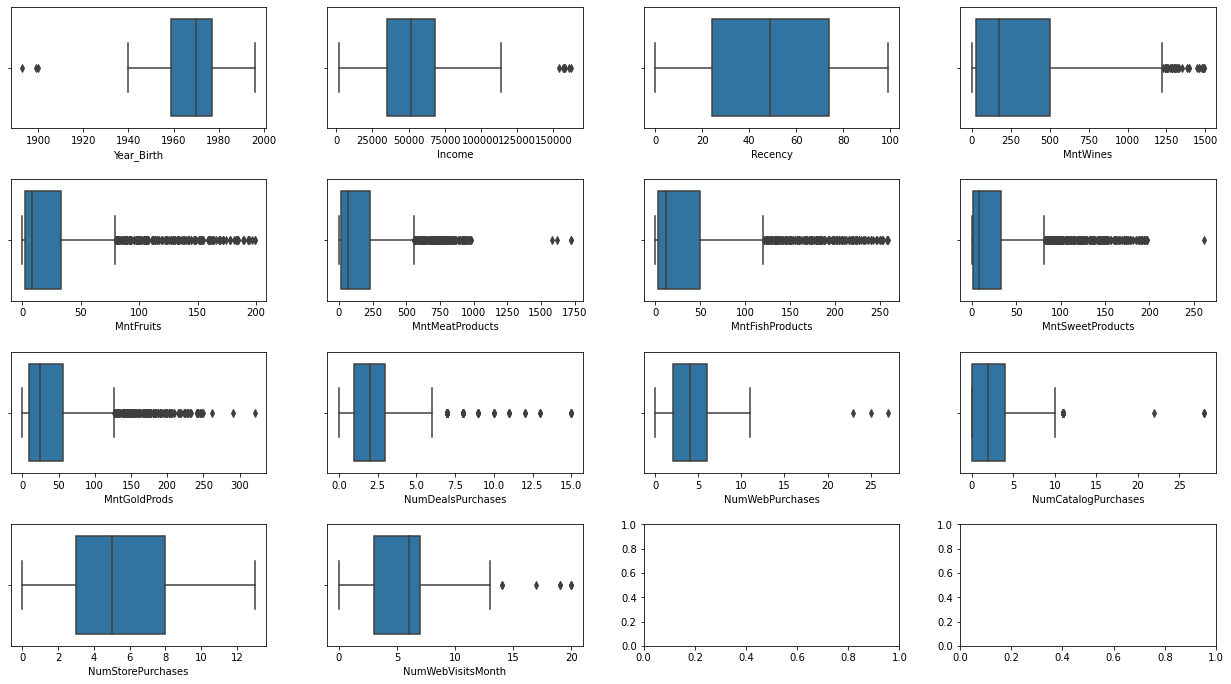

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(18, 10))
fig.tight_layout(pad=3.0)#espaço entre as figuras

sbn.boxplot(mlp['Year_Birth'], ax=axes[0,0])
sbn.boxplot(mlp['Income'], ax=axes[0,1])
sbn.boxplot(mlp['Recency'], ax=axes[0,2])
sbn.boxplot(mlp['MntWines'], ax=axes[0,3])
sbn.boxplot(mlp['MntFruits'], ax=axes[1,0])
sbn.boxplot(mlp['MntMeatProducts'], ax=axes[1,1])
sbn.boxplot(mlp['MntFishProducts'], ax=axes[1,2])
sbn.boxplot(mlp['MntSweetProducts'], ax=axes[1,3])
sbn.boxplot(mlp['MntGoldProds'], ax=axes[2,0])
sbn.boxplot(mlp['NumDealsPurchases'], ax=axes[2,1])
sbn.boxplot(mlp['NumWebPurchases'], ax=axes[2,2])
sbn.boxplot(mlp['NumCatalogPurchases'], ax=axes[2,3])
sbn.boxplot(mlp['NumStorePurchases'], ax=axes[3,0])
sbn.boxplot(mlp['NumWebVisitsMonth'], ax=axes[3,1])

Year_Birth, Income: outliers de caracteristicas dos clientes provavelmente excluir
<br>NumDeals/Web/Catalog: outliers comportamentais, entender o volume
<br>Mnt: visualmente temos muitos outliers entender o volume real de clientes nessas condições


In [22]:
#função retirada do site: https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414
def identifica_outlier(coluna):
  sorted(coluna)
  Q1,Q3 = np.percentile(coluna , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [23]:
for column in mlp_out:
  l,u = identifica_outlier(mlp_out[column])
  print("[Outliers] {0}: {1}".format(column, mlp_out.loc[(mlp_out[column] < l) | (mlp_out[column] > u)]['ID'].nunique()))  

[Outliers] ID: 0
[Outliers] Year_Birth: 3
[Outliers] Income: 0
[Outliers] MntWines: 35
[Outliers] MntFruits: 227
[Outliers] MntMeatProducts: 175
[Outliers] MntFishProducts: 223
[Outliers] MntSweetProducts: 248
[Outliers] MntGoldProds: 207
[Outliers] NumDealsPurchases: 86
[Outliers] NumWebPurchases: 4
[Outliers] NumCatalogPurchases: 23
[Outliers] NumStorePurchases: 0
[Outliers] NumWebVisitsMonth: 8


In [24]:
#Pelo fato do Income estar como float o calculo aplicado não surtiu efeito, apliquei uma segmentação manual
print("[Outliers] Income: {0}".format(mlp.loc[mlp.Income > 200000]['ID'].nunique()))

[Outliers] Income: 0


# **Analise exploratória dos Dados**

## *(1): Cadastrais*

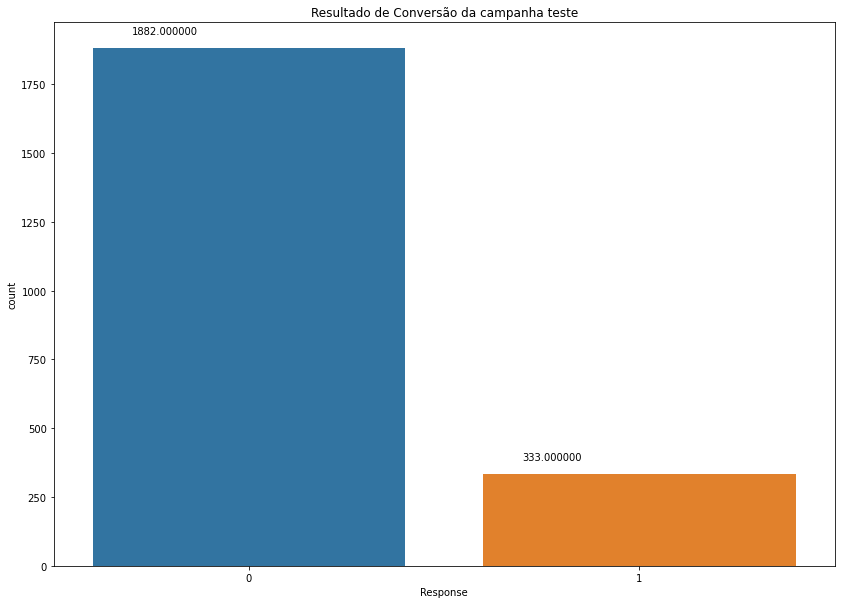

In [ ]:
plt.figure(figsize=(14,10))
plt.title('Resultado de Conversão da campanha teste')
plt.xlabel('Resposta')
plt.ylabel('Total de respondentes')

ax = sbn.countplot(x="Response", data=mlp)

for p in ax.patches:
  ax.annotate('{:f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [ ]:
total = mlp.ID.count()
conv = mlp.loc[mlp['Response'] == 1].ID.count()
print('A taxa de conversão foi de: ', round(conv/(total) * 100,2), '%')

A taxa de conversão foi de:  15.03 %


In [ ]:
mlp.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Meses_cadastro,idade,total_mnt,frequencia
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,105.633333,64,1617,25
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,87.300000,67,27,6
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,93.933333,56,776,21
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,88.166667,37,53,8
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,88.900000,40,422,19


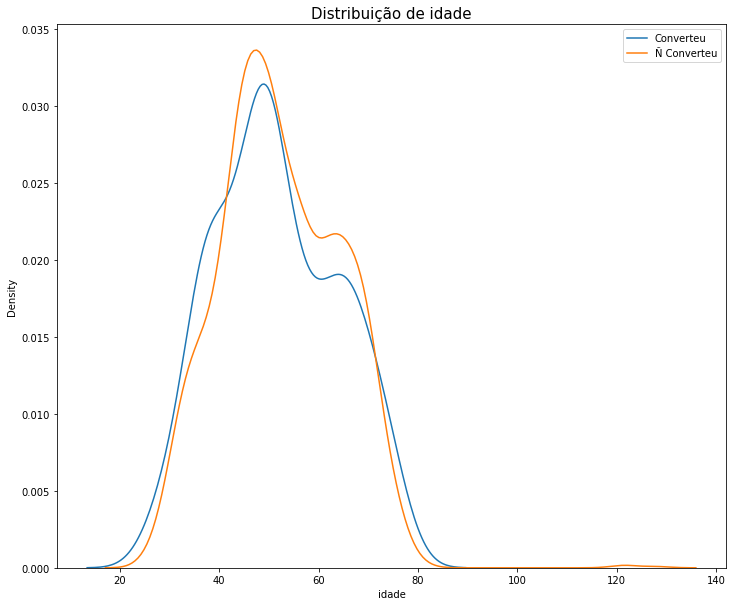

In [ ]:
plt.figure(figsize=(12,10))

sbn.distplot(Conv1['idade'], label='Converteu',hist=False)
sbn.distplot(Conv0['idade'], label='Ñ Converteu', hist=False)

plt.title('Distribuição de idade', size = 15)
plt.legend()
plt.show()

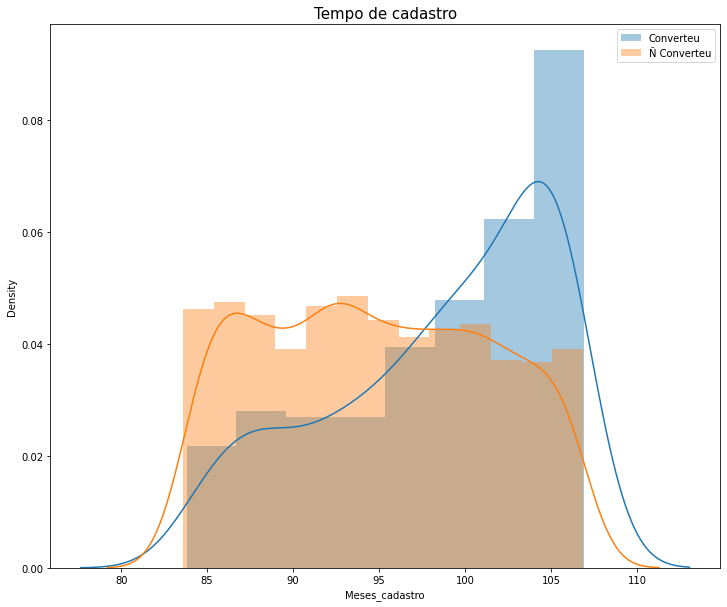

In [ ]:
plt.figure(figsize=(12,10))

sbn.distplot(Conv1['Meses_cadastro'], label='Converteu')
sbn.distplot(Conv0['Meses_cadastro'], label='Ñ Converteu')

plt.title('Tempo de cadastro', size = 15)
plt.legend()
plt.show()
#Tempo de cadastro parece um fator importante para a conversão

In [ ]:
mlp.groupby(["Response"]).Meses_cadastro.mean()

Response
0    94.344315
1    98.069069
Name: Meses_cadastro, dtype: float64

In [ ]:
mlp.loc[mlp['Response'] == 1].groupby(['Meses_cadastro']).ID.count()

Meses_cadastro
83      1
84      9
85      6
86      7
87     10
88     11
89      6
90      6
91     11
92      8
93      7
94     15
95     10
96      9
97     17
98     16
99     17
100    17
101    20
102    12
103    29
104    23
105    37
106    29
Name: ID, dtype: int64

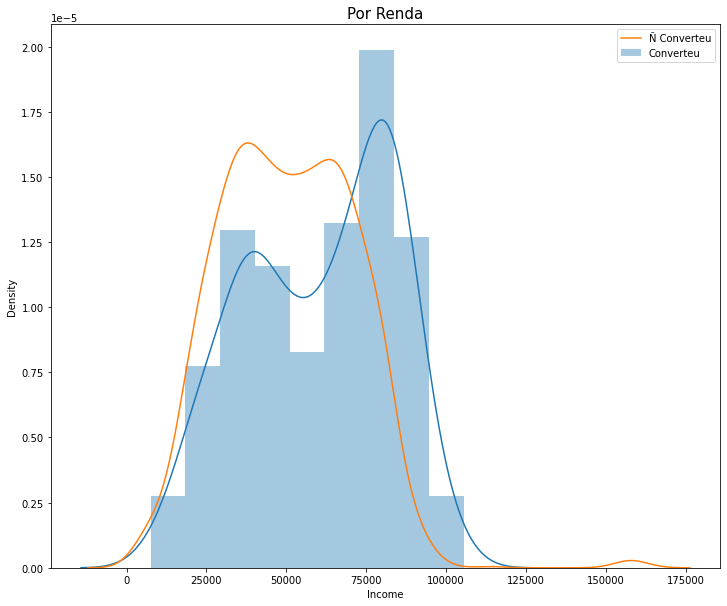

In [ ]:
plt.figure(figsize=(12,10))

sbn.distplot(Conv1['Income'], label='Converteu')
sbn.distplot(Conv0['Income'], label='Ñ Converteu', hist=False)

plt.title('Por Renda', size = 15)
plt.legend()
plt.show()

In [ ]:
mlp.groupby(["Response"]).Income.mean()

Response
0    50511.913390
1    60209.675676
Name: Income, dtype: float64

In [ ]:
mlp.loc[mlp['Response'] == 1].Income.mean() / mlp.loc[mlp['Response'] == 0].Income.mean()

1.1919896047252667

Response  Education 
0         2n Cycle       9.458023
          Basic          2.763018
          Graduation    51.168969
          Master        16.418704
          PhD           20.191286
1         2n Cycle       6.606607
          Basic          0.600601
          Graduation    45.645646
          Master        16.816817
          PhD           30.330330
Name: ID, dtype: float64

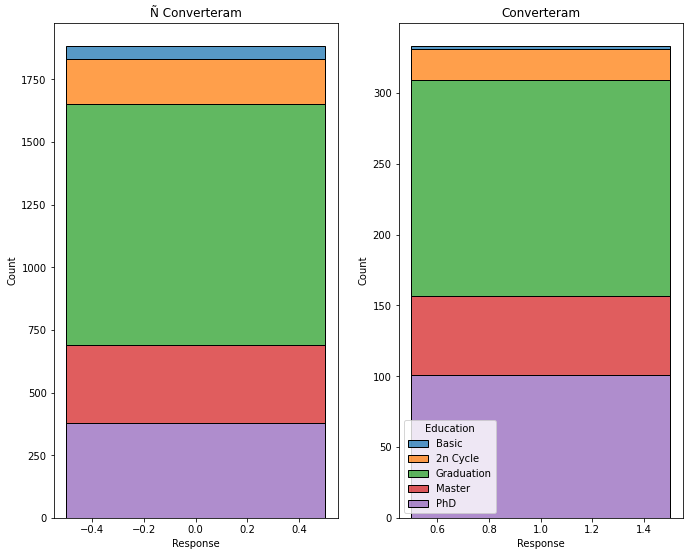

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
fig.tight_layout(pad=3.0)#espaço entre as figuras

ordem = ['Basic','2n Cycle','Graduation','Master','PhD']

sbn.histplot(x="Response", hue='Education', data=Conv0, multiple="stack", hue_order = ordem, ax=axes[0], legend=False).set_title("Ñ Converteram")
sbn.histplot(x="Response", hue='Education', data=Conv1, multiple="stack", hue_order = ordem, ax=axes[1]).set_title("Converteram")
#Dados que com uma visão % do total PhD converteram + porém Mestres converteram - não parece que temos uma curva de converção dado o nivel de graduação

In [ ]:
pd.DataFrame(mlp.groupby(["Response", "Education"]).ID.count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).reset_index()

,Response,Education,ID
0,0,2n Cycle,9.458023
1,0,Basic,2.763018
2,0,Graduation,51.168969
3,0,Master,16.418704
4,0,PhD,20.191286
5,1,2n Cycle,6.606607
6,1,Basic,0.600601
7,1,Graduation,45.645646
8,1,Master,16.816817
9,1,PhD,30.330330


In [ ]:
pd.DataFrame(mlp.groupby(["Response","Education"]).Income.mean()).reset_index()

,Response,Education,Income
0,0,2n Cycle,46617.792135
1,0,Basic,20377.423077
2,0,Graduation,50788.536864
3,0,Master,51813.022654
4,0,PhD,54700.639474
5,1,2n Cycle,55848.681818
6,1,Basic,18456.000000
7,1,Graduation,60920.460526
8,1,Master,59012.071429
9,1,PhD,61580.722772


Response  Marital_Status
0         Divorced           9.776833
          Married           40.329437
          Nulo               0.106270
          Single            19.500531
          Together          27.205101
          Widow              3.081828
1         Divorced          14.414414
          Married           29.429429
          Nulo               0.600601
          Single            32.132132
          Together          18.018018
          Widow              5.405405
Name: ID, dtype: float64

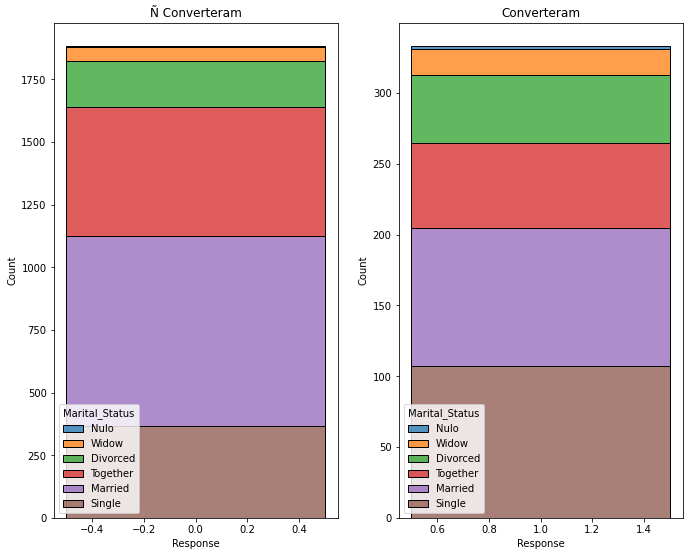

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
fig.tight_layout(pad=3.0)#espaço entre as figuras

ordem = ['Nulo','Widow','Divorced','Together','Married','Single']

sbn.histplot(x="Response", hue='Marital_Status', data=Conv0, multiple="stack", hue_order=ordem, ax=axes[0]).set_title("Ñ Converteram")
sbn.histplot(x="Response", hue='Marital_Status', data=Conv1, multiple="stack", hue_order=ordem, ax=axes[1]).set_title("Converteram")
#Dados que com uma visão % do total PhD converteram + porém Mestres converteram - não parece que temos uma curva de converção dado o nivel de graduação

mlp.groupby(["Response", "Marital_Status"]).ID.count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

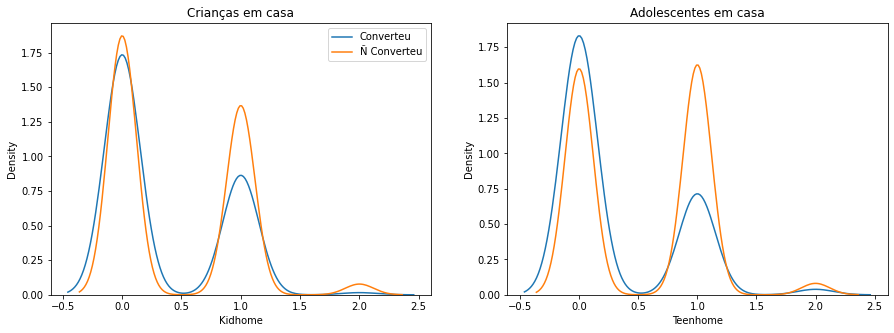

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sbn.distplot(Conv1['Kidhome'], label='Converteu',hist=False, ax=axes[0])
sbn.distplot(Conv0['Kidhome'], label='Ñ Converteu', hist=False, ax=axes[0])
axes[0].set_title('Crianças em casa')
axes[0].legend()

sbn.distplot(Conv1['Teenhome'], label='Converteu',hist=False, ax=axes[1])
sbn.distplot(Conv0['Teenhome'], label='Ñ Converteu', hist=False, ax=axes[1])
axes[1].set_title('Adolescentes em casa')

plt.show()

## *(2): Consumo*

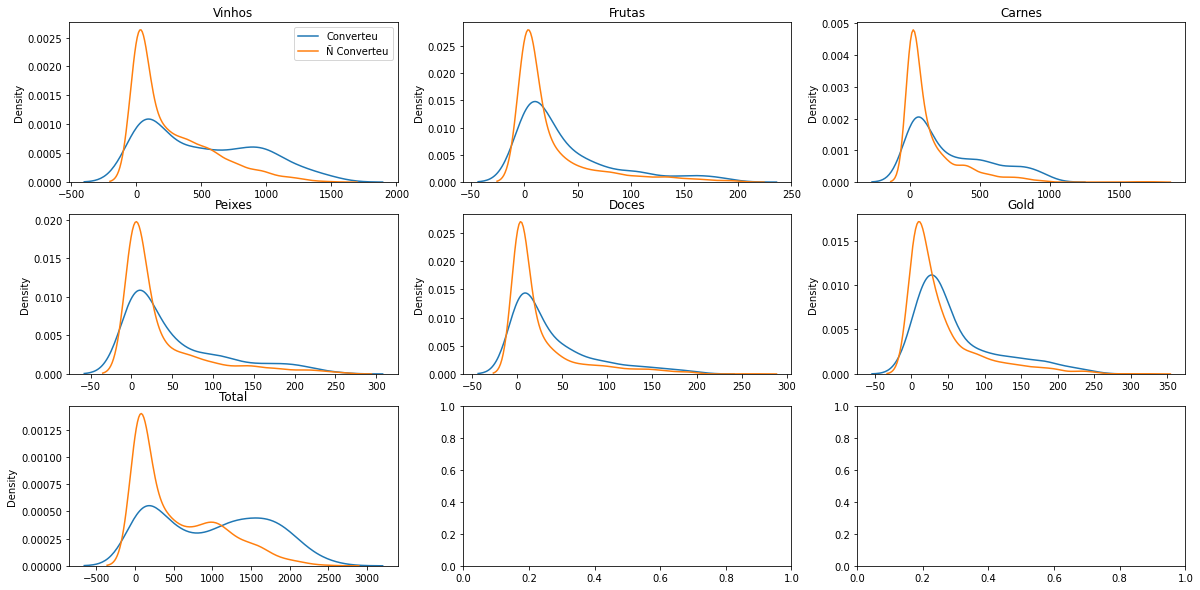

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

sbn.distplot(Conv1['MntWines'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 0])
sbn.distplot(Conv0['MntWines'], label='Ñ Converteu', hist=False, axlabel=False,ax=axes[0, 0])
axes[0, 0].set_title('Vinhos')
axes[0, 0].legend()

sbn.distplot(Conv1['MntFruits'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 1])
sbn.distplot(Conv0['MntFruits'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[0, 1])
axes[0, 1].set_title('Frutas')

sbn.distplot(Conv1['MntMeatProducts'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 2])
sbn.distplot(Conv0['MntMeatProducts'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[0, 2])
axes[0, 2].set_title('Carnes')

sbn.distplot(Conv1['MntFishProducts'], label='Converteu',hist=False, axlabel=False, ax=axes[1, 0])
sbn.distplot(Conv0['MntFishProducts'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[1, 0])
axes[1, 0].set_title('Peixes')

sbn.distplot(Conv1['MntSweetProducts'], label='Converteu',hist=False, axlabel=False, ax=axes[1, 1])
sbn.distplot(Conv0['MntSweetProducts'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[1, 1])
axes[1, 1].set_title('Doces')

sbn.distplot(Conv1['MntGoldProds'], label='Converteu',hist=False, axlabel=False, ax=axes[1, 2])
sbn.distplot(Conv0['MntGoldProds'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[1, 2])
axes[1, 2].set_title('Gold')

sbn.distplot(Conv1['total_mnt'], label='Converteu',hist=False, axlabel=False, ax=axes[2, 0])
sbn.distplot(Conv0['total_mnt'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[2, 0])
axes[2, 0].set_title('Total')

plt.show()
#

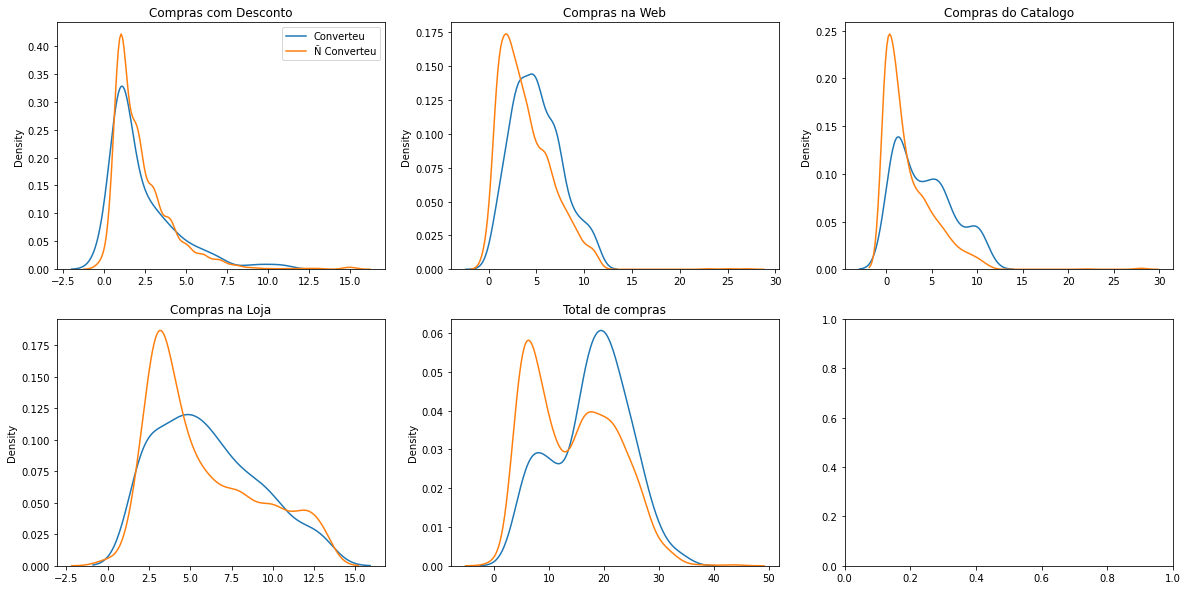

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sbn.distplot(Conv1['NumDealsPurchases'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 0])
sbn.distplot(Conv0['NumDealsPurchases'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[0, 0])
axes[0, 0].set_title('Compras com Desconto')
axes[0, 0].legend()

sbn.distplot(Conv1['NumWebPurchases'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 1])
sbn.distplot(Conv0['NumWebPurchases'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[0, 1])
axes[0, 1].set_title('Compras na Web')

sbn.distplot(Conv1['NumCatalogPurchases'], label='Converteu',hist=False, axlabel=False, ax=axes[0, 2])
sbn.distplot(Conv0['NumCatalogPurchases'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[0, 2])
axes[0, 2].set_title('Compras do Catalogo')

sbn.distplot(Conv1['NumStorePurchases'], label='Converteu',hist=False, axlabel=False, ax=axes[1, 0])
sbn.distplot(Conv0['NumStorePurchases'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[1, 0])
axes[1, 0].set_title('Compras na Loja')

sbn.distplot(Conv1['frequencia'], label='Converteu',hist=False, axlabel=False, ax=axes[1, 1])
sbn.distplot(Conv0['frequencia'], label='Ñ Converteu', hist=False, axlabel=False, ax=axes[1, 1])
axes[1, 1].set_title('Total de compras')

plt.show()

##*(3): Campanhas anteriores*

In [ ]:
mlp.loc[mlp['Response'] == 1]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Meses_cadastro,idade,total_mnt,frequencia
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,105.633333,64,1617,25
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1,96.466667,47,46,6
15,2114,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,3,11,1,102.933333,75,1315,26
33,7373,1952,PhD,Divorced,46610.0,0,2,2012-10-29,8,96,12,96,33,22,43,6,4,1,6,6,0,0,0,0,0,0,3,11,1,103.800000,69,302,17
39,2968,1943,PhD,Divorced,48948.0,0,0,2013-02-01,53,437,8,206,160,49,42,2,7,10,5,6,1,0,0,0,0,0,3,11,1,100.633333,78,902,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,7118,1957,Graduation,Married,73803.0,0,1,2012-08-01,61,833,80,363,52,26,174,2,9,5,6,6,1,0,0,0,0,0,3,11,1,106.766667,64,1528,22
2198,2632,1954,Graduation,Married,50501.0,1,1,2013-06-18,10,297,0,38,13,0,152,7,5,4,4,6,1,0,0,0,0,0,3,11,1,96.066667,67,500,20
2202,11133,1973,PhD,Nulo,48432.0,0,1,2012-10-18,3,322,3,50,4,3,42,5,7,1,6,8,0,0,0,0,0,0,3,11,1,104.166667,48,424,19
2221,7366,1982,Master,Single,75777.0,0,0,2013-07-04,12,712,26,538,69,13,80,1,3,6,11,1,0,1,1,0,0,0,3,11,1,95.533333,39,1438,21


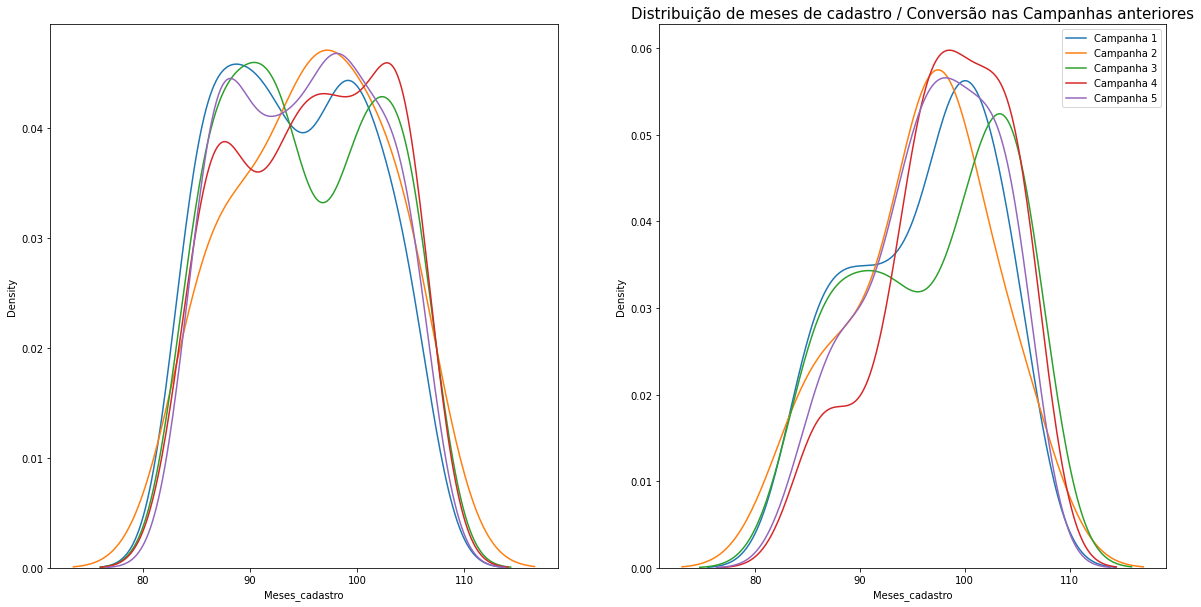

In [ ]:
fig, axes = pyplot.subplots(1, 2, figsize=(20, 10))

sbn.distplot(mlp['Meses_cadastro'].loc[mlp['AcceptedCmp1'] == 1], label='Campanha 1',hist=False, ax=axes[0])
sbn.distplot(mlp['Meses_cadastro'].loc[mlp['AcceptedCmp2'] == 1], label='Campanha 2',hist=False, ax=axes[0])
sbn.distplot(mlp['Meses_cadastro'].loc[mlp['AcceptedCmp3'] == 1], label='Campanha 3',hist=False, ax=axes[0])
sbn.distplot(mlp['Meses_cadastro'].loc[mlp['AcceptedCmp4'] == 1], label='Campanha 4',hist=False, ax=axes[0])
sbn.distplot(mlp['Meses_cadastro'].loc[mlp['AcceptedCmp5'] == 1], label='Campanha 5',hist=False, ax=axes[0])

sbn.distplot(Conv1['Meses_cadastro'].loc[Conv1['AcceptedCmp1'] == 1], label='Campanha 1',hist=False, ax=axes[1])
sbn.distplot(Conv1['Meses_cadastro'].loc[Conv1['AcceptedCmp2'] == 1], label='Campanha 2',hist=False, ax=axes[1])
sbn.distplot(Conv1['Meses_cadastro'].loc[Conv1['AcceptedCmp3'] == 1], label='Campanha 3',hist=False, ax=axes[1])
sbn.distplot(Conv1['Meses_cadastro'].loc[Conv1['AcceptedCmp4'] == 1], label='Campanha 4',hist=False, ax=axes[1])
sbn.distplot(Conv1['Meses_cadastro'].loc[Conv1['AcceptedCmp5'] == 1], label='Campanha 5',hist=False, ax=axes[1])

plt.title('Distribuição de meses de cadastro / Conversão nas Campanhas anteriores', size = 15)
plt.legend()
plt.show()

#**Classificação RFM**

##Criação

In [25]:
mlp_rfm = mlp[['ID','Response','Recency','frequencia','total_mnt']]

In [26]:
mlp_rfm.loc[mlp_rfm['Recency'] < 0]

,ID,Response,Recency,frequencia,total_mnt


In [27]:
mlp_rfm.loc[mlp_rfm['frequencia'] < 0]

,ID,Response,Recency,frequencia,total_mnt


In [28]:
mlp_rfm.loc[mlp_rfm['total_mnt'] < 0]

,ID,Response,Recency,frequencia,total_mnt


In [29]:
mlp_rfm['r_quartil'] = pd.qcut(mlp_rfm['Recency'], 4, ['1','2','3','4'])
mlp_rfm['f_quartil'] = pd.qcut(mlp_rfm['frequencia'], 4, ['1','2','3','4'])
mlp_rfm['m_quartil'] = pd.qcut(mlp_rfm['total_mnt'], 4, ['1','2','3','4'])

In [30]:
mlp_rfm['RFM'] = mlp_rfm['r_quartil'].astype('int64') + mlp_rfm['f_quartil'].astype('int64') + mlp_rfm['m_quartil'].astype('int64')

##Categorização

In [31]:
mlp_rfm.head()

,ID,Response,Recency,frequencia,total_mnt,r_quartil,f_quartil,m_quartil,RFM
0,5524,1,58,25,1617,3,4,4,11
1,2174,0,38,6,27,2,1,1,4
2,4141,0,26,21,776,2,3,3,8
3,6182,0,26,8,53,2,1,1,4
4,5324,0,94,19,422,4,3,3,10


In [32]:
mlp_rfm.groupby("RFM").ID.count()

RFM
3     128
4     184
5     244
6     296
7     229
8     337
9     284
10    265
11    172
12     76
Name: ID, dtype: int64

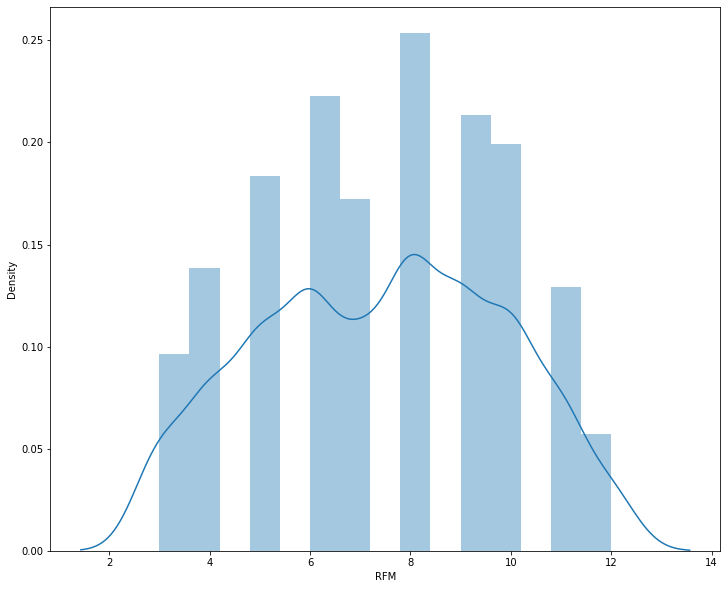

In [33]:
plt.figure(figsize=(12,10))
fig.tight_layout(pad=3.0)#espaço entre as figuras
sbn.distplot(mlp_rfm['RFM'], label='RFM')
plt.show()

In [34]:
def rfm_categoria(df):
    if df['RFM'] > 10:
        return 'Melhores'
    elif ((df['RFM'] >= 9) and (df['RFM'] < 11)):
        return 'Alto'
    elif ((df['RFM'] >= 7) and (df['RFM'] < 9)):
        return 'Medio'
    elif ((df['RFM'] >= 5) and (df['RFM'] < 7)):
        return 'Baixo'
    elif ((df['RFM'] >= 3) and (df['RFM'] < 5)):
        return 'Atenção'
    else:
        return 'Não Categorizado'

mlp_rfm['rfm_tier'] = mlp_rfm.apply(rfm_categoria, axis=1)

mlp_rfm.head()

,ID,Response,Recency,frequencia,total_mnt,r_quartil,f_quartil,m_quartil,RFM,rfm_tier
0,5524,1,58,25,1617,3,4,4,11,Melhores
1,2174,0,38,6,27,2,1,1,4,Atenção
2,4141,0,26,21,776,2,3,3,8,Medio
3,6182,0,26,8,53,2,1,1,4,Atenção
4,5324,0,94,19,422,4,3,3,10,Alto


In [35]:
def rfm_categoria_v(df):
    if df['RFM'] > 10:
        return 5
    elif ((df['RFM'] >= 9) and (df['RFM'] < 11)):
        return 4
    elif ((df['RFM'] >= 7) and (df['RFM'] < 9)):
        return 3
    elif ((df['RFM'] >= 5) and (df['RFM'] < 7)):
        return 2
    elif ((df['RFM'] >= 3) and (df['RFM'] < 5)):
        return 1
    else:
        return 0

mlp_rfm['rfm_tier_v'] = mlp_rfm.apply(rfm_categoria_v, axis=1)

mlp_rfm.head()

,ID,Response,Recency,frequencia,total_mnt,r_quartil,f_quartil,m_quartil,RFM,rfm_tier,rfm_tier_v
0,5524,1,58,25,1617,3,4,4,11,Melhores,5
1,2174,0,38,6,27,2,1,1,4,Atenção,1
2,4141,0,26,21,776,2,3,3,8,Medio,3
3,6182,0,26,8,53,2,1,1,4,Atenção,1
4,5324,0,94,19,422,4,3,3,10,Alto,4


##Analise

In [36]:
mlp_rfm.groupby(['Response','rfm_tier']).ID.count()

Response  rfm_tier
0         Alto        440
          Atenção     276
          Baixo       487
          Medio       476
          Melhores    203
1         Alto        109
          Atenção      36
          Baixo        53
          Medio        90
          Melhores     45
Name: ID, dtype: int64

In [37]:
mlp_rfm.groupby(['Response','rfm_tier']).ID.count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

Response  rfm_tier
0         Alto        23.379384
          Atenção     14.665250
          Baixo       25.876727
          Medio       25.292242
          Melhores    10.786397
1         Alto        32.732733
          Atenção     10.810811
          Baixo       15.915916
          Medio       27.027027
          Melhores    13.513514
Name: ID, dtype: float64

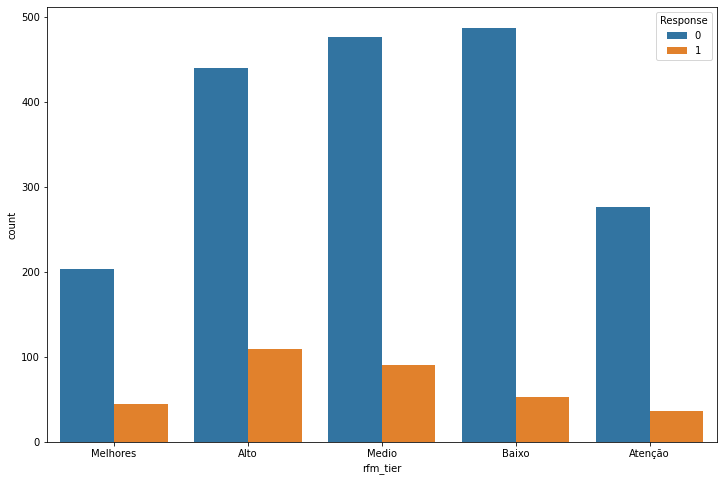

In [38]:
tier_count = pd.DataFrame({'count' : mlp_rfm.groupby( [ 'Response', 'rfm_tier'] ).size()}).reset_index()

plt.figure(figsize=(12,8))
ordem = ['Melhores','Alto','Medio','Baixo','Atenção']
sbn.barplot(x="rfm_tier", y="count", hue='Response', order=ordem, data=tier_count )
plt.show()


In [39]:
tier_count

,Response,rfm_tier,count
0,0,Alto,440
1,0,Atenção,276
2,0,Baixo,487
3,0,Medio,476
4,0,Melhores,203
5,1,Alto,109
6,1,Atenção,36
7,1,Baixo,53
8,1,Medio,90
9,1,Melhores,45


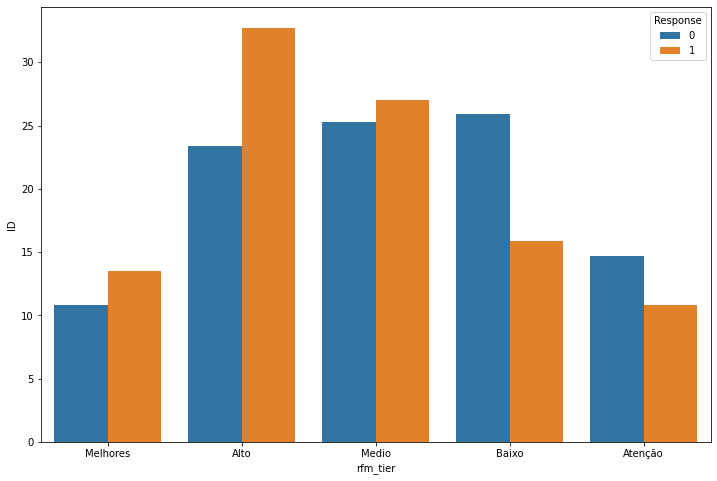

In [ ]:
tier_perc = pd.DataFrame(mlp_rfm.groupby(['Response','rfm_tier']).ID.count().groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).reset_index()

plt.figure(figsize=(12,8))
ordem = ['Melhores','Alto','Medio','Baixo','Atenção']
sbn.barplot(x="rfm_tier", y="ID", hue='Response', order=ordem, data=tier_perc )
plt.show()

In [ ]:
tier_perc

,Response,rfm_tier,ID
0,0,Alto,23.379384
1,0,Atenção,14.665250
2,0,Baixo,25.876727
3,0,Medio,25.292242
4,0,Melhores,10.786397
5,1,Alto,32.732733
6,1,Atenção,10.810811
7,1,Baixo,15.915916
8,1,Medio,27.027027
9,1,Melhores,13.513514


In [ ]:
total = mlp.ID.count()
conv = mlp.loc[mlp['Response'] == 1].ID.count()
print('A conversão da campanha toda foi de: ', round(conv/(total) * 100,2), '%')
print('Custo total: ', total*3)
print('Receita: ', conv*11)
print('Lucro: ', (conv*11)-(total*3))

A conversão da campanha toda foi de:  15.03 %
Custo total:  6645
Receita:  3663
Lucro:  -2982


In [ ]:
for c in mlp_rfm.rfm_tier.unique():
  total = mlp_rfm.loc[mlp_rfm['rfm_tier'] == c].ID.count()
  conv = mlp_rfm.loc[(mlp_rfm['rfm_tier'] == c) & (mlp_rfm['Response'] == 1)].ID.count()
  print('Grupo: {0}'.format(c))
  print('\t Conversão: {0}%'.format(round(conv/(total) * 100,2)))
  print('\t Custo: ', total*3)
  print('\t Receita: ', conv*11)
  print('\t Lucro: ', (conv*11)-(total*3))

Grupo: Melhores
	 Conversão: 18.15%
	 Custo:  744
	 Receita:  495
	 Lucro:  -249
Grupo: Atenção
	 Conversão: 11.54%
	 Custo:  936
	 Receita:  396
	 Lucro:  -540
Grupo: Medio
	 Conversão: 15.9%
	 Custo:  1698
	 Receita:  990
	 Lucro:  -708
Grupo: Alto
	 Conversão: 19.85%
	 Custo:  1647
	 Receita:  1199
	 Lucro:  -448
Grupo: Baixo
	 Conversão: 9.81%
	 Custo:  1620
	 Receita:  583
	 Lucro:  -1037


In [ ]:
mlp = pd.merge(mlp, mlp_rfm[['ID','rfm_tier']], on=['ID'], how='left')

#**Modelo**

Dado a matriz de correlação abaixo, baseado na correlação da variavel resposta optei por fazer uma linha de corte de + ou - 0.15
E para o volume de compras usar somente total_mnt já que as compras por categoria tem uma correlação alta entre elas (para evitar um overfit)

##Base para o Modelo

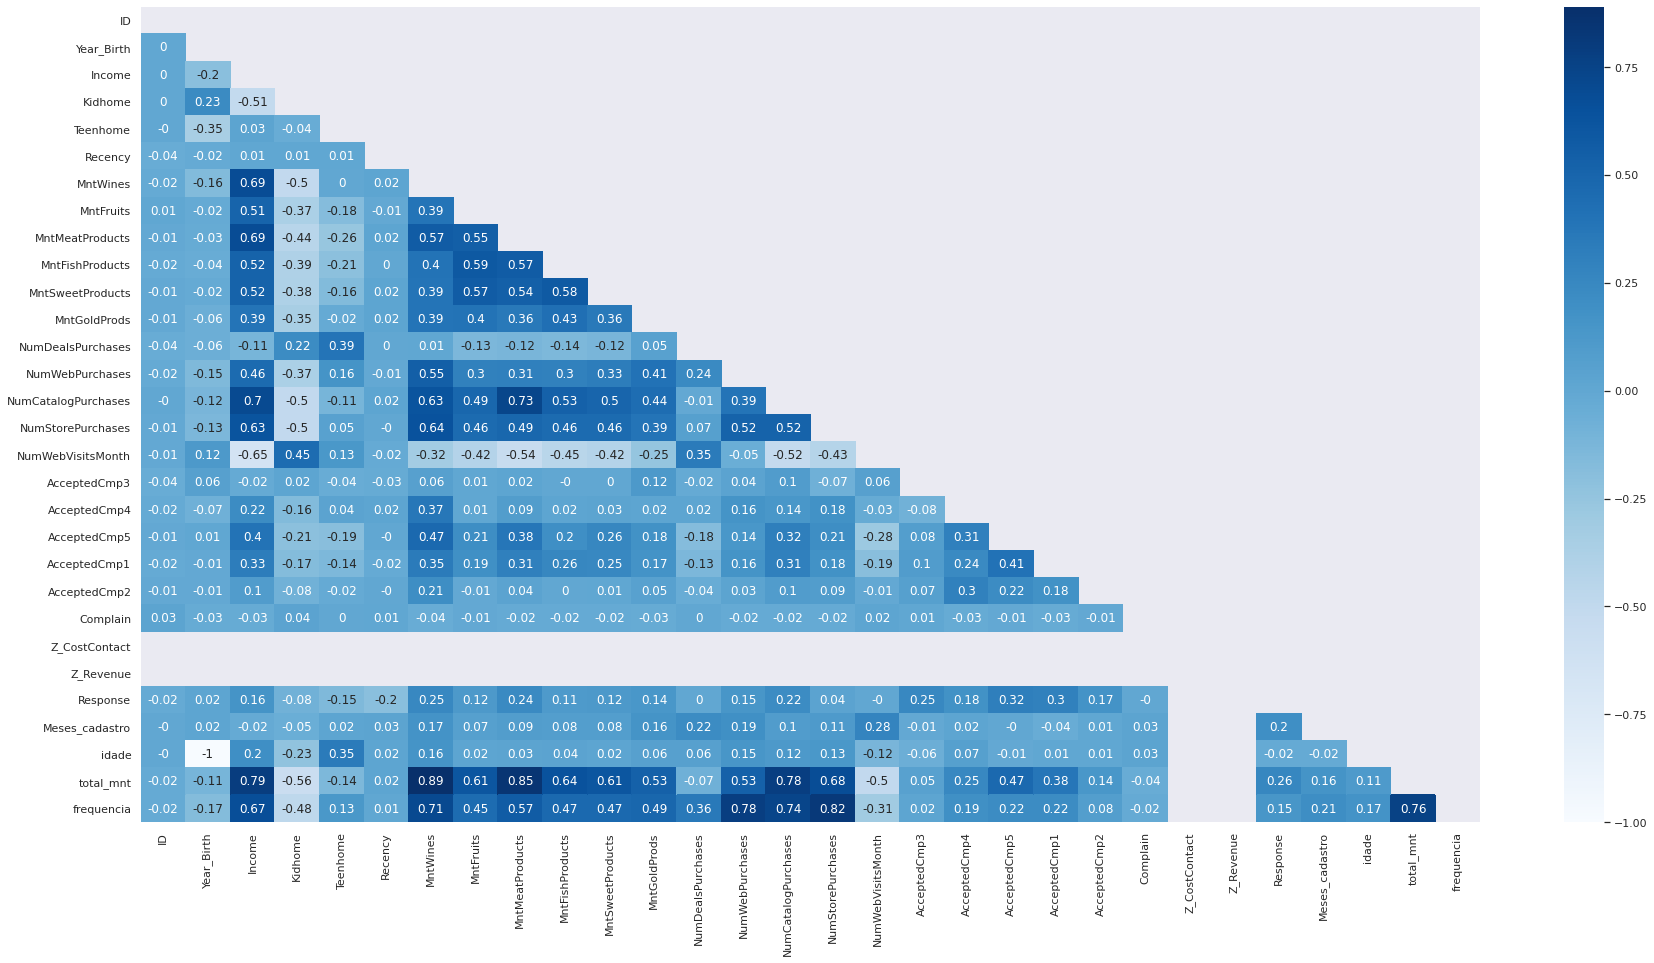

In [ ]:
corrMatrix = round(mlp.corr(),2)
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
cmap = sbn.color_palette("Blues", as_cmap=True)

sbn.set(rc={'figure.figsize':(30,15)})
sbn.heatmap(corrMatrix, annot=True, mask=mask, cmap=cmap)
plt.show()

In [ ]:
#Selecionar todas as variaveis que tem uma correlação + ou - de 0.15 com a variavel resposta
dados_modelo = mlp[['ID','Response','Income','Teenhome','Recency','MntWines','MntMeatProducts','NumWebPurchases','NumCatalogPurchases','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Meses_cadastro','total_mnt','frequencia']]

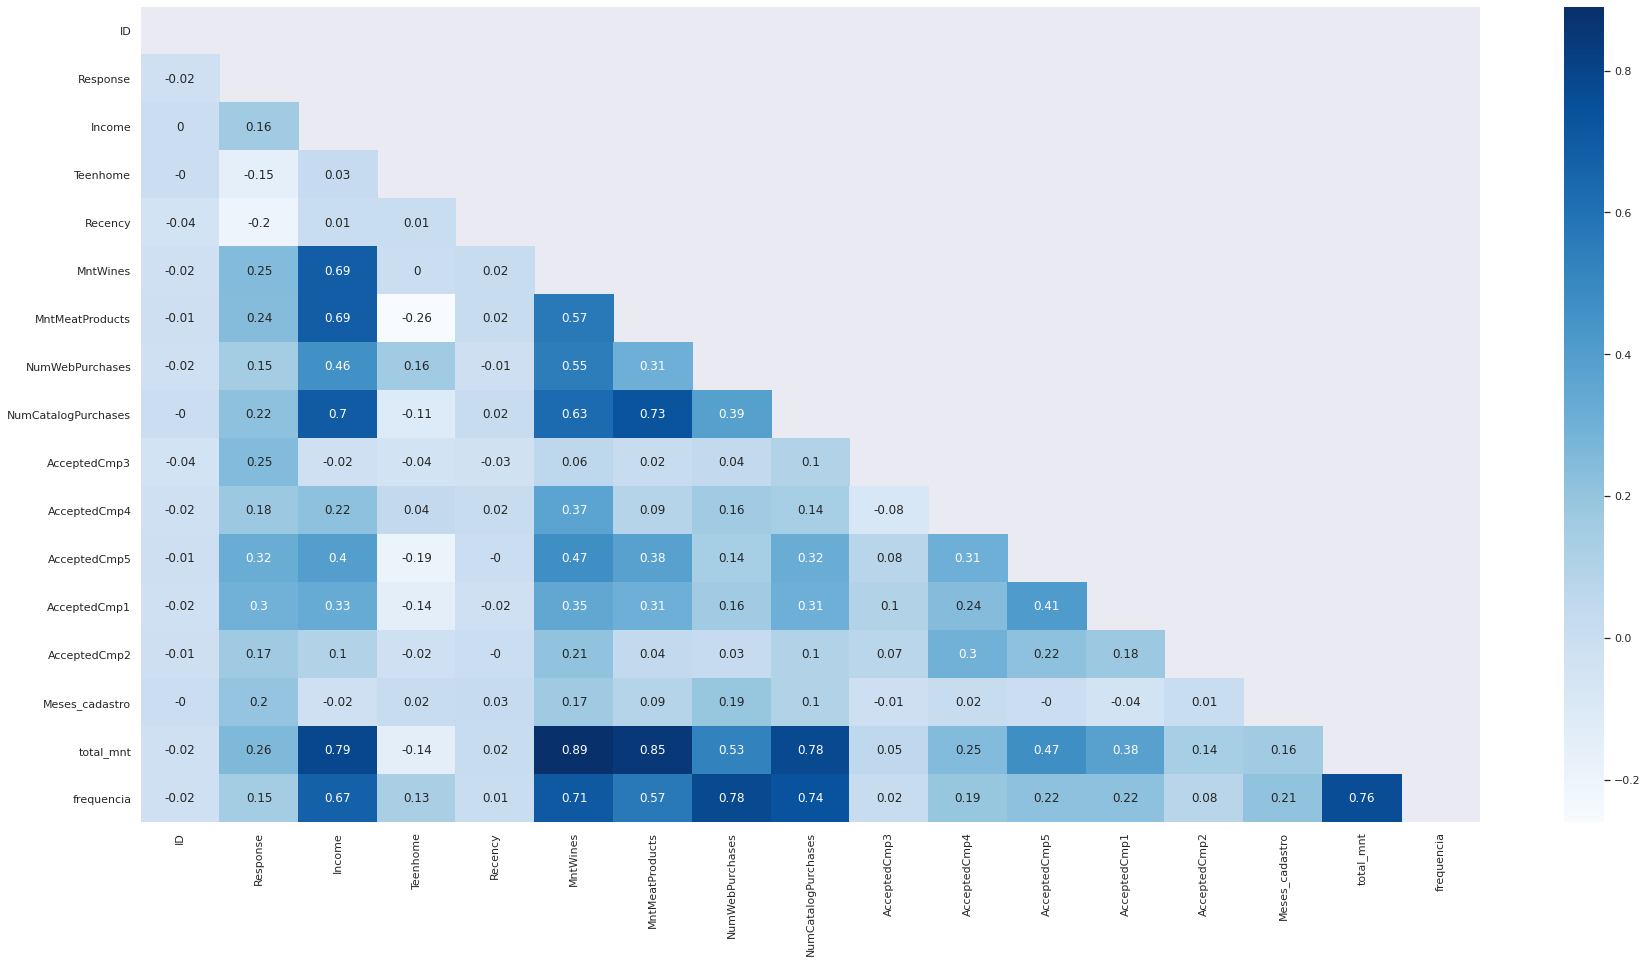

In [ ]:
corrMatrix = round(dados_modelo.corr(),2)
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
cmap = sbn.color_palette("Blues", as_cmap=True)

sbn.set(rc={'figure.figsize':(30,15)})
sbn.heatmap(corrMatrix, annot=True, mask=mask, cmap=cmap)
plt.show()

#Verifico a relação entre as variaveis para tirar over fit
#Variavel total_mnt tem correlação com diversas outras variaveis, por tanto vamos deixar somente ela
#NumWebPurchases + Frequencia + total_mnt tem uma correlação forte então vamos deixar somente total_mnt


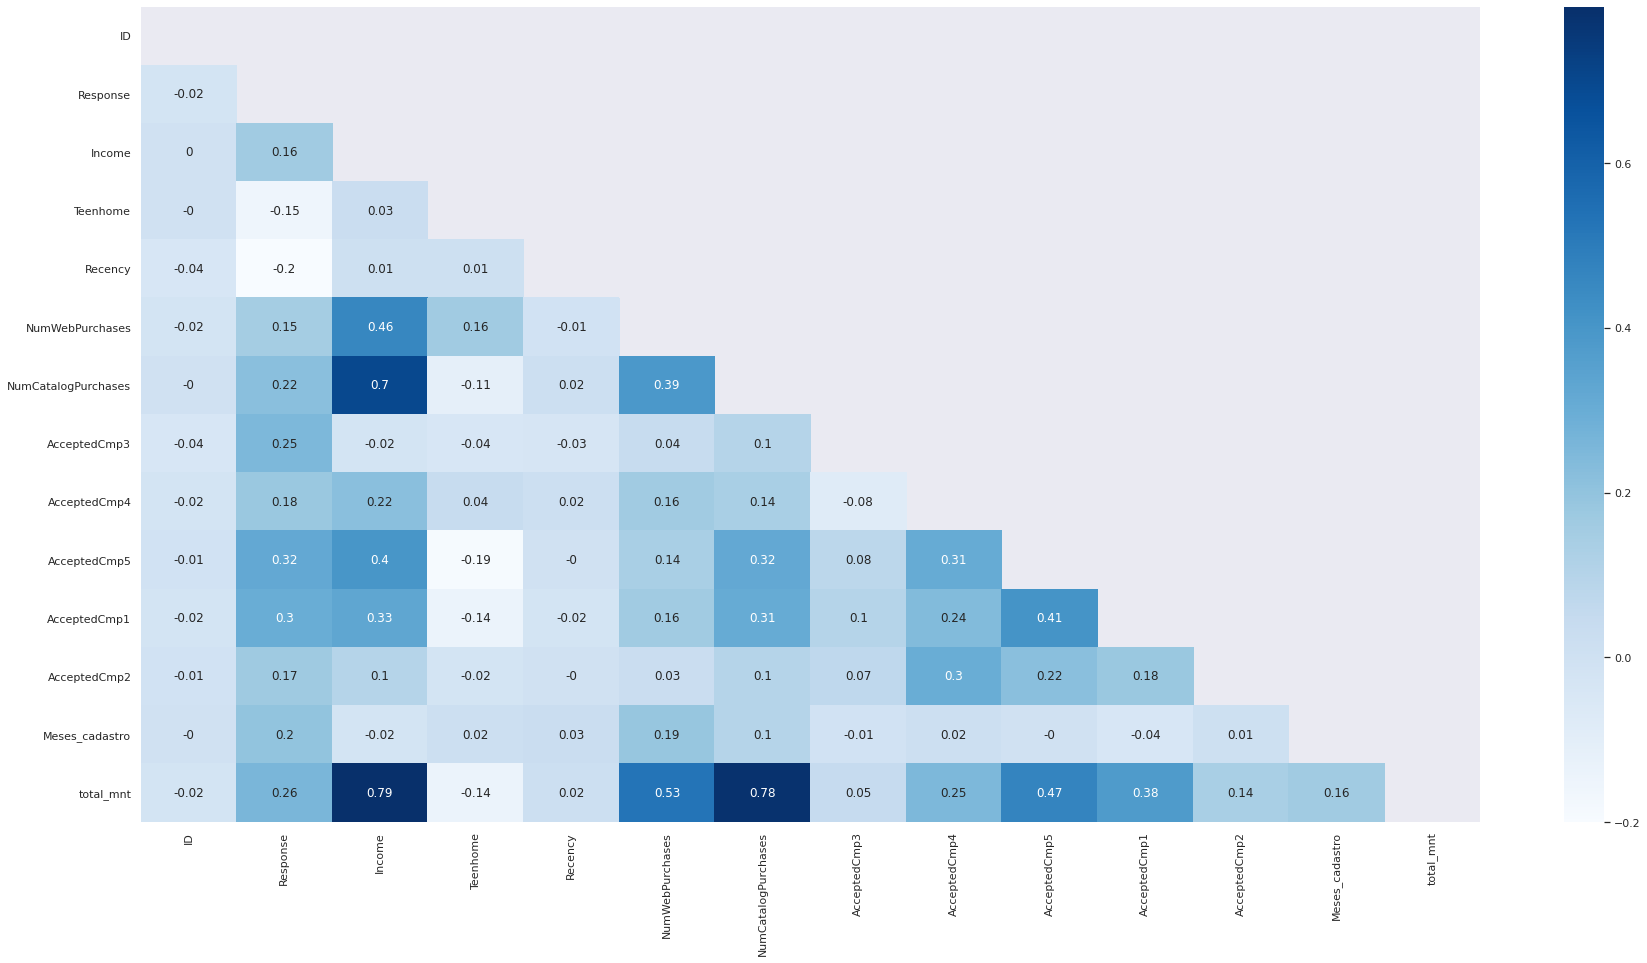

In [ ]:
dados_modelo = mlp[['ID','Response','Income','Teenhome','Recency','NumWebPurchases','NumCatalogPurchases','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Meses_cadastro','total_mnt']]
corrMatrix = round(dados_modelo.corr(),2)
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
cmap = sbn.color_palette("Blues", as_cmap=True)

sbn.set(rc={'figure.figsize':(30,15)})
sbn.heatmap(corrMatrix, annot=True, mask=mask, cmap=cmap)
plt.show()

##Separar base Treino e Teste

In [ ]:
train_row = np.random.rand(len(dados_modelo)) < 0.8

In [ ]:
train = dados_modelo[train_row]

In [ ]:
train.head()

,ID,Response,Income,Teenhome,Recency,NumWebPurchases,NumCatalogPurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Meses_cadastro,total_mnt
0,5524,1,58138.0,0,58,8,10,0,0,0,0,0,105.633333,1617
1,2174,0,46344.0,1,38,1,1,0,0,0,0,0,87.300000,27
3,6182,0,26646.0,0,26,2,0,0,0,0,0,0,88.166667,53
4,5324,0,58293.0,0,94,5,3,0,0,0,0,0,88.900000,422
5,7446,0,62513.0,1,16,6,4,0,0,0,0,0,93.300000,716


In [ ]:
x_train = train.drop(['ID', 'Response'], axis=1)

In [ ]:
from sklearn import preprocessing

In [ ]:
names = x_train.columns

scaler = preprocessing.StandardScaler()

scaled_x_train = scaler.fit_transform(x_train)
scaled_x_train = pd.DataFrame(scaled_x_train, columns=names)

In [ ]:
y_train = train['Response']

In [ ]:
test = dados_modelo[~train_row]

In [ ]:
x_test = test.drop(['ID', 'Response'], axis=1)

In [ ]:
names = x_test.columns

scaler = preprocessing.StandardScaler()

scaled_x_test = scaler.fit_transform(x_test)
scaled_x_test = pd.DataFrame(scaled_x_test, columns=names)

In [ ]:
y_test = test['Response']

In [ ]:
len(test)

447

In [ ]:
x_total = dados_modelo.drop(['ID', 'Response'], axis=1)

In [ ]:
names = x_total.columns

scaler = preprocessing.StandardScaler()

scaled_x_total = scaler.fit_transform(x_total)
scaled_x_total = pd.DataFrame(scaled_x_total, columns=names)

In [ ]:
y_total = dados_modelo['Response']

##Processamento do Modelo (Regressão)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
logisticRegr = LogisticRegression()

In [ ]:
logisticRegr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##Resultado (Regressão)

In [ ]:
predictions = logisticRegr.predict(x_test)

In [ ]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.8568232662192393


In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)

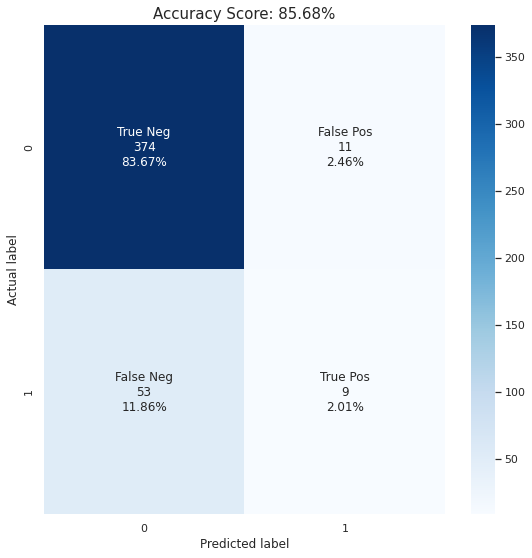

In [ ]:
plt.figure(figsize=(9,9))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sbn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

all_sample_title = 'Accuracy Score: {0:.2%}'.format(score)
plt.title(all_sample_title, size = 15);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
predictions = logisticRegr.predict(x_total)

In [ ]:
score = logisticRegr.score(x_total, y_total)
print(score)

0.8510158013544018


In [ ]:
cm = metrics.confusion_matrix(y_total, predictions)

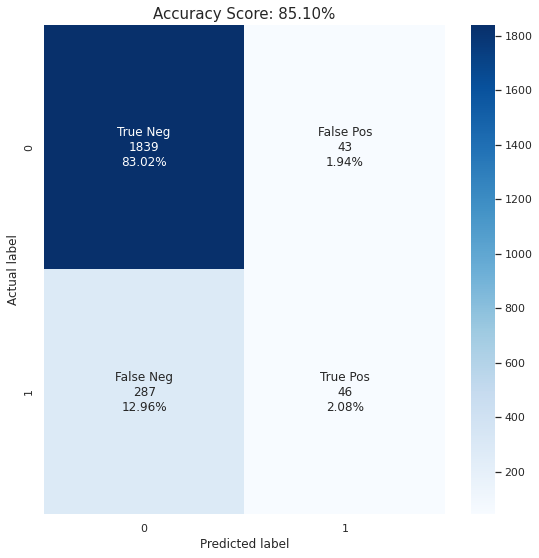

In [ ]:
plt.figure(figsize=(9,9))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sbn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

all_sample_title = 'Accuracy Score: {0:.2%}'.format(score)
plt.title(all_sample_title, size = 15);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

##Processamento do Modelo (Arvore de decisão)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
score_tree = round(tree_model.score(x_test,y_test) * 100, 2)
print(score_tree)

86.8


##Resultado (Arvore de decisão)

In [ ]:
predictions = tree_model.predict(x_test)

In [ ]:
tree_score = tree_model.score(x_test, y_test)
print(score)

0.8510158013544018


In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)

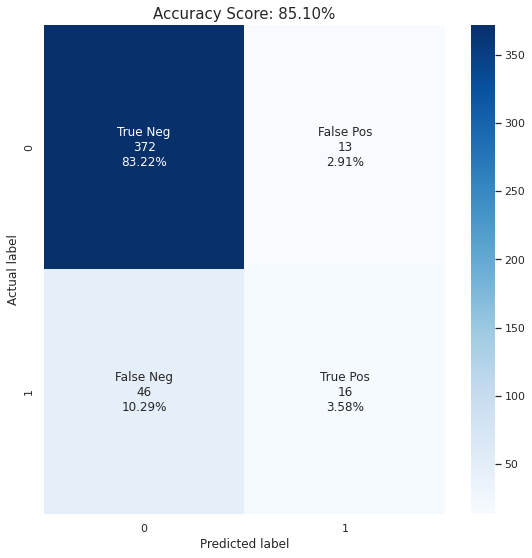

In [ ]:
plt.figure(figsize=(9,9))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sbn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

all_sample_title = 'Accuracy Score: {0:.2%}'.format(score)
plt.title(all_sample_title, size = 15);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
predictions = tree_model.predict(x_total)

In [ ]:
tree_score = tree_model.score(x_total, y_total)
print(score)

0.8510158013544018


In [ ]:
cm = metrics.confusion_matrix(y_total, predictions)

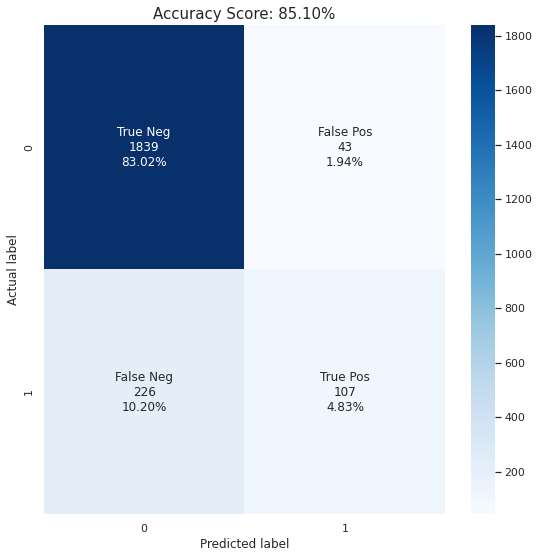

In [ ]:
plt.figure(figsize=(9,9))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sbn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

all_sample_title = 'Accuracy Score: {0:.2%}'.format(score)
plt.title(all_sample_title, size = 15);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');